In [2]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
from pycocotools.coco import COCO
import time

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.models import mobilenet_v3_large, resnet152
import torch.nn as nn
from torch.nn import functional as F

In [1]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d watchman/rtsd-dataset
# !unzip rtsd-dataset.zip
# !rm rtsd-dataset.zip
# !cp -r rtsd-frames/rtsd-frames/ .
# !rm -r rtsd-frames/rtsd-frames/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/chkpt_model1_d_6.pth .
!cp /content/drive/MyDrive/chkpt_m1_d_6.pth .

cp: cannot stat '/content/drive/MyDrive/chkpt_m1_d_6.pth': No such file or directory


In [ ]:
!cp chkpt_model1_d_3.pth /content/drive/MyDrive
!cp chkpt_m1_d_3.pth /content/drive/MyDrive
# !cp chkpt_model1_d_1.pth /content/drive/MyDrive
# !cp chkpt_m1_d_1.pth /content/drive/MyDrive
# !cp chkpt_model1_d_2.pth /content/drive/MyDrive
# !cp chkpt_m1_d_2.pth /content/drive/MyDrive

In [11]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

n_epochs = 10
batch_size = 8
classes = 2
device

'cpu'

In [6]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [7]:
df_train_anno = dataset('.', 'train_anno.json')
df_val_anno = dataset('.', 'val_anno.json')
df_train_anno_reduced = dataset('.', 'train_anno_reduced.json')

In [8]:
# Приведем все знаки к одному классу
df_train_anno_1 = df_train_anno.copy()
df_train_anno_1['category_id'] = 1

df_val_anno_1 = df_val_anno.copy()
df_val_anno_1['category_id'] = 1

df_train_anno_reduced_1 = df_train_anno_reduced.copy()
df_train_anno_reduced_1['category_id'] = 1

In [ ]:
class RTSD_dataset_my(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
        self.df = self.df.groupby('file_name', as_index=False).agg(list)
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        img = Image.open(os.path.join(self.path_img, name_img))
      
        boxes = []
        for b in self.df.loc[index,'bbox']:
            bb = [b[0], b[1], b[0] + b[2], b[1] + b[3]]
            boxes.append(bb)   

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.Tensor(self.df.loc[index, 'category_id']).to(torch.int64)
        img_id = torch.tensor([self.df.loc[index, 'image_id'][0]])
        
        areas = []
        for i in self.df.loc[index,'area']:
            areas.append(self.df.loc[index,'area'])
        areas = torch.as_tensor(areas[0], dtype=torch.float32)
       
        iscrowd = torch.zeros(len(self.df.loc[index,'iscrowd'])).to(torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        
        img = img / 255

        return img, my_annotation

    def __len__(self):
        
        return self.df.shape[0]

In [ ]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
df1 = RTSD_dataset_my('./', df_train_anno_1,transforms=get_transform())
df11 = RTSD_dataset_my('./', df_val_anno_1,transforms=get_transform())

In [ ]:
data_loader_train1 = torch.utils.data.DataLoader(df1,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)


data_loader_val1 = torch.utils.data.DataLoader(df11,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)


In [ ]:
# dir(models.detection.faster_rcnn)

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath, map_location=device)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['model_state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['loss_val']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min

from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler).to(device)

params1 = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params1)


model1, optimizer1, start_epoch, loss1_val = load_ckp('./chkpt_model1_d_6.pth', model, optimizer)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 26.3MB/s]


In [ ]:
loss1_train = []
loss1_val = []

for epoch in range(7, n_epochs):
    start = time.time()
    model1.train()
    for i, batch in enumerate(data_loader_train1):
        optimizer1.zero_grad()
        loss_train = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model1(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_train += losses.item()
        losses.backward()
        optimizer1.step()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_train = (loss_train / i)
    loss1_train.append(loss11_train)
    
    print('Эпоха train:', epoch,'Итераций:', i, 'train loss:', (loss_train / i))
    
    for i, batch in enumerate(data_loader_val1):
        optimizer1.zero_grad()
        loss_val = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
              loss_dict = model1(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_val += losses.item()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_val = (loss_val / i)
    loss1_val.append(loss11_val)
    end = time.time()
    print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
    print('Эпоха val:', epoch, 'Итераций:', i, 'val loss:', (loss_val / i))
    
        
    torch.save({'epoch': epoch,
                    'model_state_dict': model1.state_dict(),
                    'optimizer_state_dict': optimizer1.state_dict(),
                    'loss_train': loss1_train,
                    'loss_val': loss1_val,
                    }, f'./chkpt_model1_d_{epoch}.pth')
    
    torch.save(model1.state_dict(), f'./chkpt_m1_d_{epoch}.pth')
    !cp chkpt_model1_d_{epoch}.pth /content/drive/MyDrive
    !cp chkpt_m1_d_{epoch}.pth /content/drive/MyDrive

epoch: 7, step: 0, loss: 0.043962448835372925
epoch: 7, step: 200, loss: 0.026536300778388977
epoch: 7, step: 400, loss: 0.018289897590875626
epoch: 7, step: 600, loss: 0.03284978121519089
epoch: 7, step: 800, loss: 0.01662551611661911
epoch: 7, step: 1000, loss: 0.017538495361804962
epoch: 7, step: 1200, loss: 0.032765619456768036
epoch: 7, step: 1400, loss: 0.014828656800091267
epoch: 7, step: 1600, loss: 0.024374350905418396
epoch: 7, step: 1800, loss: 0.018561601638793945
epoch: 7, step: 2000, loss: 0.03581811115145683
epoch: 7, step: 2200, loss: 0.0287337563931942
epoch: 7, step: 2400, loss: 0.019617890939116478
epoch: 7, step: 2600, loss: 0.04486819729208946
epoch: 7, step: 2800, loss: 0.03980123624205589
epoch: 7, step: 3000, loss: 0.019867265596985817
epoch: 7, step: 3200, loss: 0.02728181891143322
epoch: 7, step: 3400, loss: 0.03486621752381325
epoch: 7, step: 3600, loss: 0.025327924638986588
epoch: 7, step: 3800, loss: 0.038975778967142105
epoch: 7, step: 4000, loss: 0.033771

In [4]:
loss_train =[3.0580113909041236e-06, 3.219942086822831e-06, 4.540103697037512e-06, 2.7347735623320603e-06, 4.814329617971333e-06,
            3.219942086822831e-06, 5.3979584313970335e-06, 3.254830276187208e-06, 6.863211228998001e-06, 5.004828504945749e-06]

In [8]:
loss_val = [2.9550460077678927e-05, 2.5064738180774908e-05, 2.250354513167762e-05, 1.565586605395835e-05,1.565586605395835e-05,
            2.5064738180774908e-05, 2.1921661055575198e-05, 1.664455227840405e-05, 1.4956581603305844e-05, 1.3431432307697833e-05]

Text(0.5, 1.0, 'backbone_mobilenet_v2')

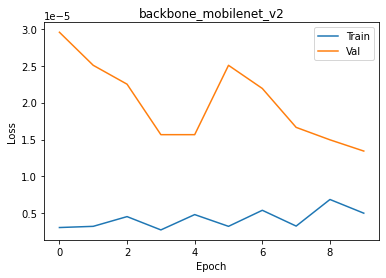

In [9]:
%matplotlib inline
# тренировка на большом датасете
t = 'backbone_mobilenet_v2'
fig, ax  = plt.subplots()
ax.plot(loss_train, label='Train')
ax.plot(loss_val, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.title('{}'.format(t))

In [16]:
transform = transforms.Compose([transforms.ToTensor(),])

In [52]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
modeld1 = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler).to(device)
checkpoint1 = torch.load('./chkpt_model1_d_5.pth', map_location=device)
modeld1.load_state_dict(checkpoint1['model_state_dict'])

<All keys matched successfully>

In [59]:
img_path = '.'
img_name = '56.jpg'
detection_threshold = 0.1
image1 = Image.open(img_name)

In [60]:
modeld1.eval()
image = transform(image1).to(device)
image = image.unsqueeze(0) # add a batch dimension
outputs = modeld1(image)
pred_classes = [i for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
pred_scores

array([0.991456  , 0.8376362 , 0.212114  , 0.12947813, 0.10696121,
       0.10531152, 0.07097223, 0.05045314], dtype=float32)

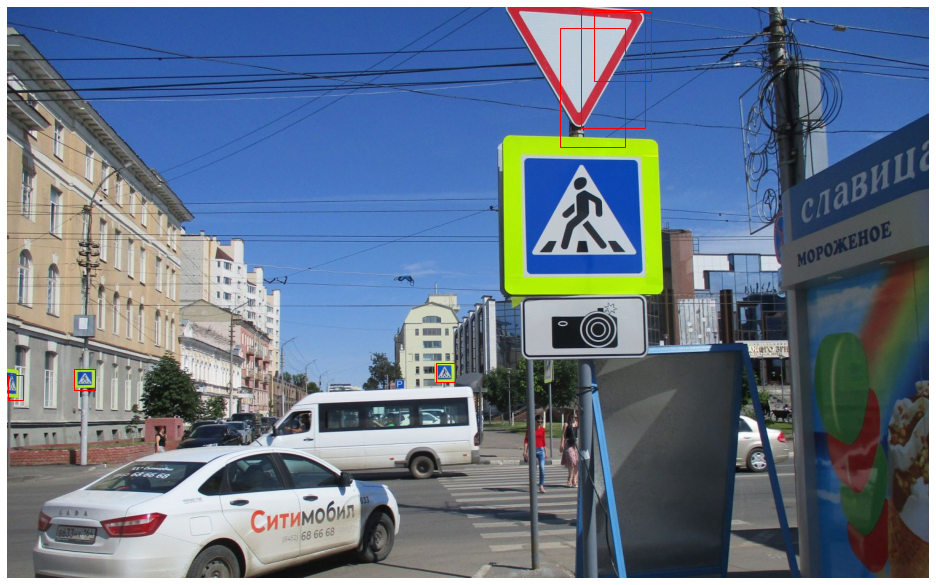

In [61]:
im = Image.open(img_name)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(im)
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.axis('off')
plt.show()